## Simulator

In [24]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4096, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-12,1e-7), # omega alpha
                                                stats.uniform(0,3)], # alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [25]:
# Simluate data 
n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 



  0%|          | 0/10000 [00:00<?, ?it/s]

Visualize 

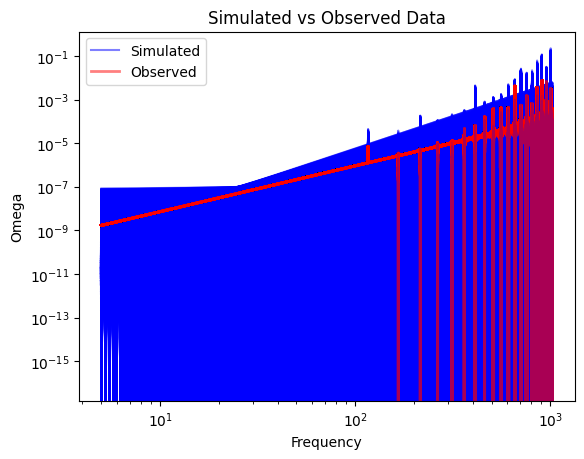

In [26]:

for i in range(len(samples)):
    if i == 0:  # Label only the first simulated dataset to avoid clutter
        plt.loglog(sim.freq, samples[i]['x'], 'b', alpha=0.5, label='Simulated')
        plt.loglog(sim.freq, obs['x'], 'r', lw=2,  alpha=0.5,label='Observed')  # Observed data
    else:
        plt.loglog(sim.freq, samples[i]['x'], 'b', alpha=0.5)
        plt.loglog(sim.freq, obs['x'], 'r', lw=2,  alpha=0.5)
        
# Adding labels and title
plt.xlabel("Frequency")
plt.ylabel("Omega")
plt.title("Simulated vs Observed Data")

# Show legend
plt.legend()
plt.show()


Plot variance of a random sample

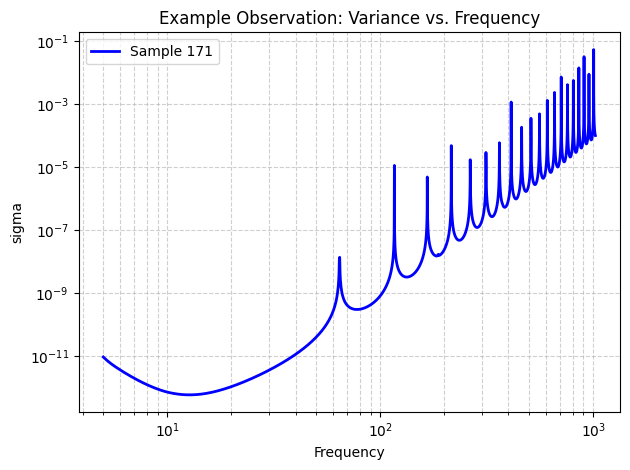

In [27]:

# Select a random index from the available samples
random_index = random.randint(0, len(samples) - 1)

# Plot the randomly chosen sample
plt.loglog(sim.freq, samples[random_index]['sigma'], 'b', lw=2, label=f"Sample {random_index}")
plt.xlabel("Frequency")
plt.ylabel("sigma")
plt.title("Example Observation: Variance vs. Frequency")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()


Plot $ \Omega$ vs frequency for three random samples

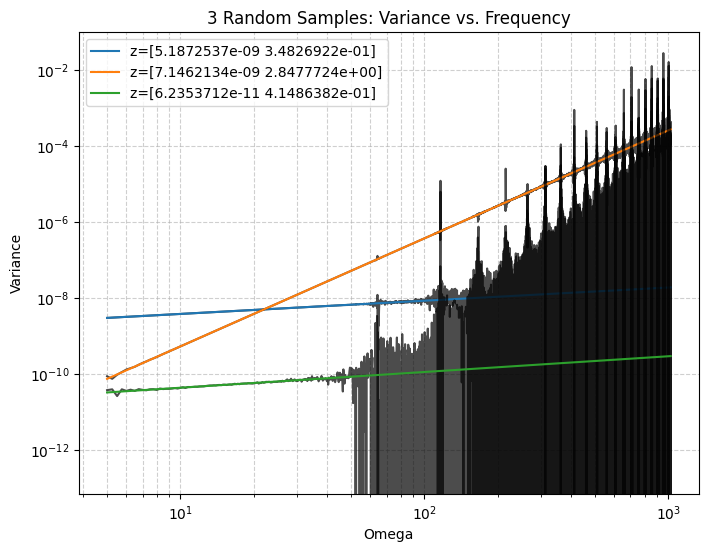

In [28]:

# Number of random samples to select
num_samples = 3  
random_indices = random.sample(range(len(samples)), num_samples)  # Select `num_samples` unique indices

plt.figure(figsize=(8, 6))

# Loop through the randomly selected indices
for i in random_indices:
    plt.loglog(sim.freq, samples[i]['x'], color='k', alpha=0.7)  # Slight transparency for clarity
    plt.loglog(sim.freq, samples[i]['m'], label=f"z={samples[i]['z']}")

# Labels, title, and grid
plt.xlabel("Omega")
plt.ylabel("Variance")
plt.title(f"{num_samples} Random Samples: Variance vs. Frequency")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.show()


In [29]:
#sim.freq

In [30]:
#samples['x']

## Variational Autoencoder

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4096, 2048)
        self.encoder_ln1 = nn.LayerNorm(2048)

        self.encoder_fc2 = nn.Linear( 2048, 1024)
        self.encoder_ln2 = nn.LayerNorm(1024)

        self.encoder_fc3 = nn.Linear(1024, 512)
        self.encoder_ln3 = nn.LayerNorm(512)

        self.encoder_fc4 = nn.Linear(512, 256)
        self.encoder_ln4 = nn.LayerNorm(256)

        self.encoder_fc5 = nn.Linear( 256, 128)
        self.encoder_ln5 = nn.LayerNorm(128)

        self.encoder_fc6 = nn.Linear(128, 64)
        self.encoder_ln6 = nn.LayerNorm(64)

        self.encoder_fc7 = nn.Linear(64, 32)
        self.encoder_ln7 = nn.LayerNorm(32)
        
        # Latent space mean and log variance
        self.fc_mu = nn.Linear(32,16) # bigger latent space improved learning 
        self.fc_logvar = nn.Linear(32, 16)

        # Decoder layers
        
        self.decoder_fc1 = nn.Linear(16,32)
        self.decoder_ln1 = nn.LayerNorm(32)

        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_ln2 = nn.LayerNorm(64)

        self.decoder_fc3 = nn.Linear(64, 128)
        self.decoder_ln3 = nn.LayerNorm(128)

        self.decoder_fc4 = nn.Linear(128, 256)
        self.decoder_ln4 = nn.LayerNorm(256)

        self.decoder_fc5 = nn.Linear(256, 512)
        self.decoder_ln5 = nn.LayerNorm(512)

        self.decoder_fc6 = nn.Linear(512, 1024)
        self.decoder_ln6 = nn.LayerNorm(1024)

        self.decoder_fc7 = nn.Linear(1024, 2048)
        self.decoder_ln7 = nn.LayerNorm(2048)

        self.decoder_fc8 = nn.Linear(2048, 4096)
        
        self.dropout = nn.Dropout(0.1)

    def encode(self, x):
        # Encode input to latent space
        
        x = F.leaky_relu(self.encoder_ln1(self.encoder_fc1(x)))
        x = F.leaky_relu(self.encoder_ln2(self.encoder_fc2(x)))
        x = F.leaky_relu(self.encoder_ln3(self.encoder_fc3(x)))
        x = F.leaky_relu(self.encoder_ln4(self.encoder_fc4(x)))
        x = F.leaky_relu(self.encoder_ln5(self.encoder_fc5(x)))
        x = F.leaky_relu(self.encoder_ln6(self.encoder_fc6(x)))
        x = F.leaky_relu(self.encoder_ln7(self.encoder_fc7(x)))
        
    
        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.leaky_relu(self.decoder_ln1(self.decoder_fc1(z)))
        z = F.leaky_relu(self.decoder_ln2(self.decoder_fc2(z)))
        z = F.leaky_relu(self.decoder_ln3(self.decoder_fc3(z)))
        z = F.leaky_relu(self.decoder_ln4(self.decoder_fc4(z)))
        z = F.leaky_relu(self.decoder_ln5(self.decoder_fc5(z)))
        z = F.leaky_relu(self.decoder_ln6(self.decoder_fc6(z)))
        z = F.leaky_relu(self.decoder_ln7(self.decoder_fc7(z)))
        
        z = self.decoder_fc8(z) #no activation for log10 data
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar
    

# Instantiate and print summary
model = VAE()
summary(model, input_size=(4096,))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       8,390,656
         LayerNorm-2                 [-1, 2048]           4,096
            Linear-3                 [-1, 1024]       2,098,176
         LayerNorm-4                 [-1, 1024]           2,048
            Linear-5                  [-1, 512]         524,800
         LayerNorm-6                  [-1, 512]           1,024
            Linear-7                  [-1, 256]         131,328
         LayerNorm-8                  [-1, 256]             512
            Linear-9                  [-1, 128]          32,896
        LayerNorm-10                  [-1, 128]             256
           Linear-11                   [-1, 64]           8,256
        LayerNorm-12                   [-1, 64]             128
           Linear-13                   [-1, 32]           2,080
        LayerNorm-14                   

In [32]:
x_samples = np.log10(np.abs(samples['x']))
m_samples = np.log10(np.abs(samples['m']))

scaler_x = StandardScaler()
scaler_m = StandardScaler()

x_samples = scaler_x.fit_transform(x_samples)
m_samples = scaler_m.fit_transform(m_samples)

# split into train+val and test sets
x_train, x_temp, m_train, m_temp = train_test_split(x_samples, m_samples, test_size=0.2, random_state=42)

# Further split train+val into separate training and validation sets for 80/10/10 split
x_val, x_test, m_val, m_test  = train_test_split(x_temp,  m_temp, test_size=0.5, random_state=42)


# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)
m_val_tensor = torch.tensor(m_val, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor) #m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor) # m_test_tensor)
val_dataset = TensorDataset(x_val_tensor, m_val_tensor) # m_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

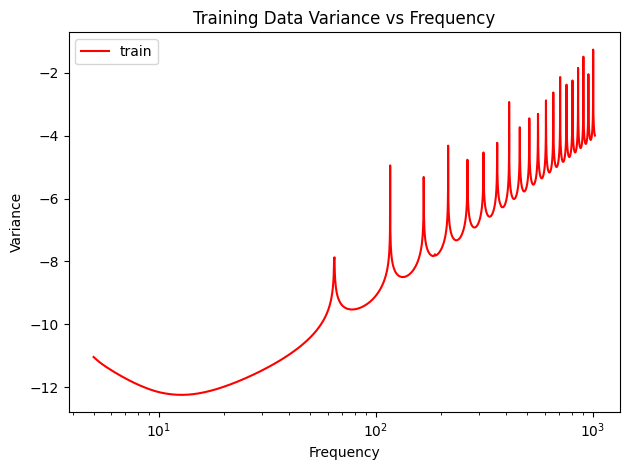

In [33]:

# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = np.log10(sim.sigma())
sig_train = np.log10(sim.sigma())
sig_val = np.log10(sim.sigma())

plt.semilogx(sim.freq, sig_test, color = 'r', label = 'train')
#plt.loglog(sim.freq,sig_test, color = 'b', label = 'test')
#plt.loglog(sim.freq,sig_val, color = 'g', label = 'validate')

plt.ylabel("Variance")
plt.xlabel("Frequency")
plt.title("Training Data Variance vs Frequency")
plt.legend()
plt.tight_layout()

plt.show()


In [34]:
# VAE Weighted Loss
def VAE_WeightedLoss(sigma, predictions, targets, mu, logvar, beta = 1.0):
    """
    Computes the total loss for a Variational Autoencoder (VAE), including:
    - Weighted Mean Squared Error (MSE) loss between predictions and targets.
    - Kullback-Leibler Divergence (KL divergence) to regularize the latent space.
    
    Args:
        sigma (list or torch.Tensor): The variance weights for each dimension.
        predictions (torch.Tensor): The reconstructed values from the VAE.
        targets (torch.Tensor): The target (original input) values.
        mu (torch.Tensor): The mean of the latent space distribution.
        logvar (torch.Tensor): The log variance of the latent space distribution.
        
    Returns:
        torch.Tensor: The total loss, combining weighted MSE loss and KL divergence.
    """
    #ensure sigma is a tensor if it is not already
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.Tensor(sigma)

    #ensure predictons and targets have same shape
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    # Weighted Mean Squared Error loss
    squared_error = 1 / sigma**2 * (predictions - targets)**2
    weighted_mse_loss = torch.mean(squared_error)

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: MSE + KL divergence
    total_loss = weighted_mse_loss + beta * kl_divergence

    return total_loss

In [35]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Variational Autoencoder
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
  # list of variances per feature

# Define early stopping parameters
patience = 5 # Number of epochs to wait for improvement
best_loss = float('inf')  # Initial best loss, set to infinity
epochs_without_improvement = 0  # Counter for the number of epochs without improvement

train_losses = []
test_losses = []
val_losses = []

test_predictions = []
test_targets_list = []
val_predictions = []
val_targets_list = []

warmup_epochs =5
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass through the VAE
        outputs, mu, logvar = model(inputs)  # Outputs, mu, logvar
        beta = min(1.0, epoch/warmup_epochs)# KL annealing over warmup epochs
        # Compute the loss
        loss = VAE_WeightedLoss(sig_train, outputs, targets, mu, logvar, beta = beta)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    model.eval()
    with torch.no_grad():   
        val_loss = 0.0
        for inputs, targets in val_loader:
            #val_predictions.clear()
            #val_targets_list.clear()
            outputs, mu, logvar = model(inputs)
            beta = min(1.0, epoch / warmup_epochs)
            loss = VAE_WeightedLoss(sig_val, outputs, targets, mu, logvar, beta=beta)
            val_loss += loss.item() * inputs.size(0)

            
            val_predictions.append(outputs)
            val_targets_list.append(targets)
        

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

    model.eval()
    with torch.no_grad():   
        test_loss = 0.0
        for inputs, targets in test_loader:
            #test_predictions.clear()
            #test_targets_list.clear()
            outputs, mu, logvar = model(inputs)
            beta = min(1.0, epoch / warmup_epochs)
            loss = VAE_WeightedLoss(sig_test, outputs, targets, mu, logvar, beta=beta)
            test_loss += loss.item() * inputs.size(0)

    
            test_predictions.append(outputs)
            test_targets_list.append(targets)
        

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train: {epoch_loss:.5f} | Val: {val_loss:.5f} | Test: {test_loss:.5f}")
    
    if epoch_loss < best_loss:
        if epoch > warmup_epochs:
            best_loss = epoch_loss
            torch.save(model.state_dict(), "best_vae_model.pt")
            epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1
        
    # Check if we've exceeded the patience
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} with no improvement for {patience} epochs.")
        break
    



Epoch [1/100] | Train: 0.01711 | Val: 0.01004 | Test: 0.00944
Epoch [2/100] | Train: 1.29862 | Val: 0.04396 | Test: 0.04212
Epoch [3/100] | Train: 0.03878 | Val: 0.03940 | Test: 0.03762
Epoch [4/100] | Train: 0.03817 | Val: 0.03933 | Test: 0.03765
Epoch [5/100] | Train: 0.03802 | Val: 0.03945 | Test: 0.03782
Epoch [6/100] | Train: 0.03808 | Val: 0.03937 | Test: 0.03762
Epoch [7/100] | Train: 0.03804 | Val: 0.03949 | Test: 0.03769
Epoch [8/100] | Train: 0.03807 | Val: 0.03936 | Test: 0.03762
Epoch [9/100] | Train: 0.03798 | Val: 0.03939 | Test: 0.03769
Epoch [10/100] | Train: 0.03806 | Val: 0.04063 | Test: 0.03873
Epoch [11/100] | Train: 0.03802 | Val: 0.03951 | Test: 0.03778
Epoch [12/100] | Train: 0.03809 | Val: 0.03953 | Test: 0.03767
Epoch [13/100] | Train: 0.03804 | Val: 0.03943 | Test: 0.03770
Epoch [14/100] | Train: 0.03810 | Val: 0.03934 | Test: 0.03761
Early stopping at epoch 14 with no improvement for 5 epochs.


In [36]:
model.load_state_dict(torch.load("best_vae_model.pt"))
model.eval()

/var/folders/63/39kkwt414rv8gx91d72hdt240000gn/T/ipykernel_35481/2409492347.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vae_mo

VAE(
  (encoder_fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (encoder_ln1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (encoder_fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (encoder_ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (encoder_fc3): Linear(in_features=1024, out_features=512, bias=True)
  (encoder_ln3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (encoder_fc4): Linear(in_features=512, out_features=256, bias=True)
  (encoder_ln4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (encoder_fc5): Linear(in_features=256, out_features=128, bias=True)
  (encoder_ln5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (encoder_fc6): Linear(in_features=128, out_features=64, bias=True)
  (encoder_ln6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (encoder_fc7): Linear(in_features=64, out_features=32, bias=True)
  (encoder_ln7): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc_

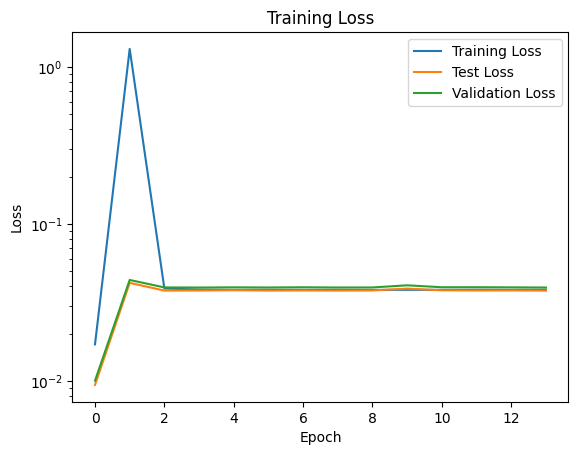

In [37]:

plt.semilogy(train_losses, label='Training Loss')
plt.semilogy(test_losses, label='Test Loss')
plt.semilogy(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [38]:
# Concatenate predictions and targets from batches

scaled_test_predictions = np.concatenate(test_predictions, axis=0)
scaled_test_targets = np.concatenate(test_targets_list, axis=0)
scaled_val_predictions = np.concatenate(val_predictions, axis=0)
scaled_val_targets = np.concatenate(val_targets_list, axis=0)



# If you're using `StandardScaler` from scikit-learn:
unscaled_predictions = scaler_m.inverse_transform(scaled_test_predictions)
unscaled_targets = scaler_m.inverse_transform(scaled_test_targets)

unscaled_val_predictions = scaler_m.inverse_transform(scaled_val_predictions)
unscaled_val_targets = scaler_m.inverse_transform(scaled_val_targets)




### Visualize unscaled data

In [39]:
"""
residuals = unscaled_predictions - unscaled_targets
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residual (Prediction - True)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (unscaled data)")
plt.grid(True)
plt.show()
""" 

'\nresiduals = unscaled_predictions - unscaled_targets\nplt.figure(figsize=(8, 6))\nplt.hist(residuals, bins=50, alpha=0.7)\nplt.axvline(0, color=\'r\', linestyle=\'--\')\nplt.xlabel("Residual (Prediction - True)")\nplt.ylabel("Frequency")\nplt.title("Histogram of Residuals (unscaled data)")\nplt.grid(True)\nplt.show()\n'

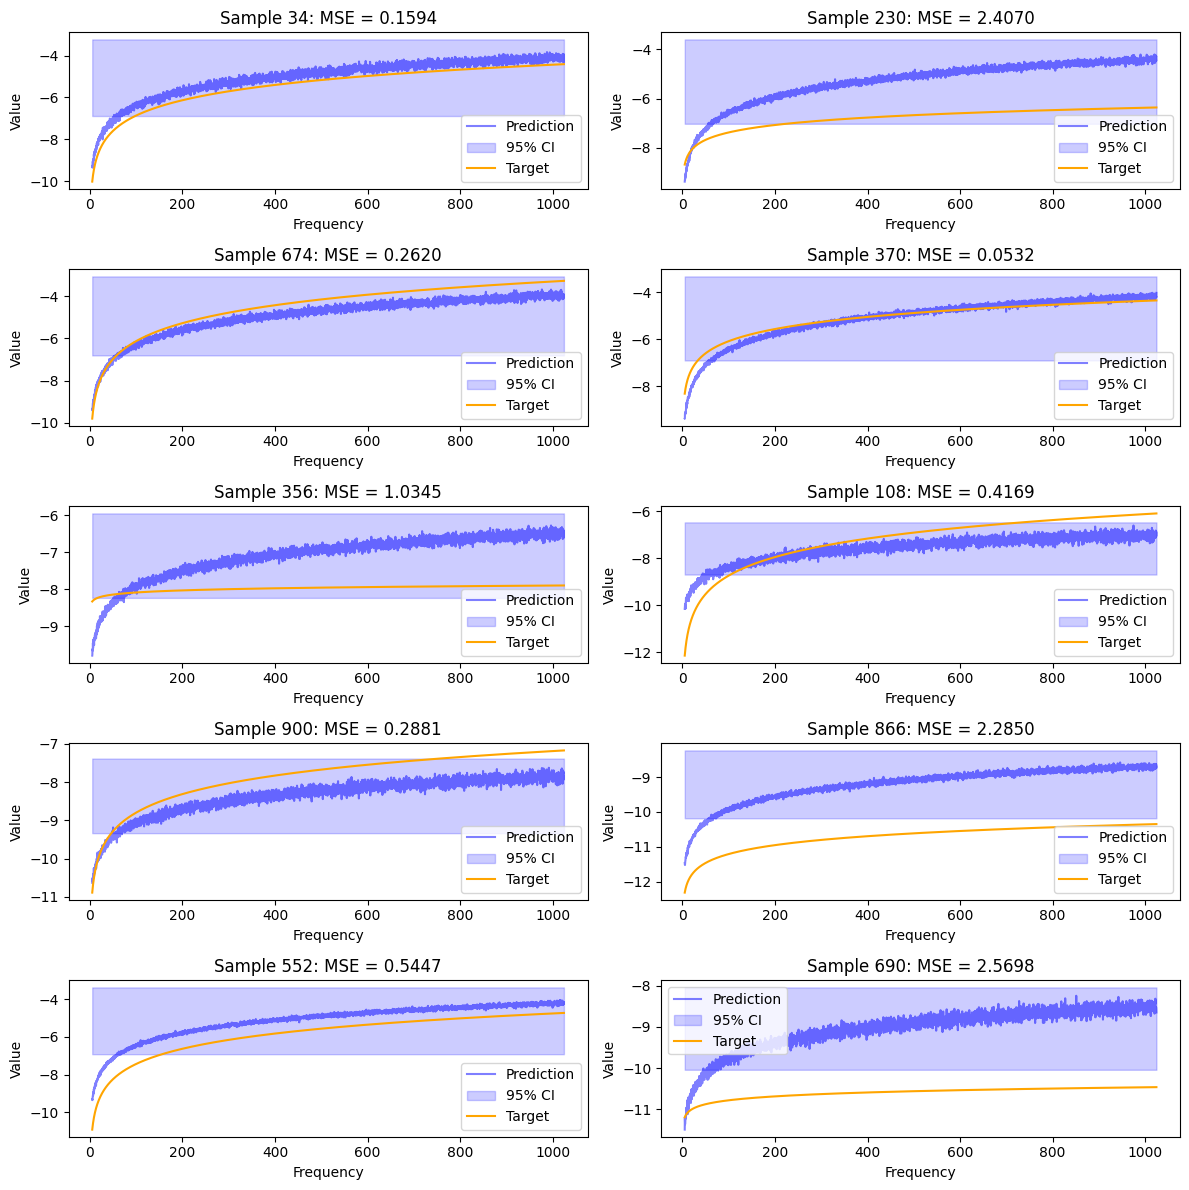

Fully unscaled


In [40]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ensure model is in evaluation mode once
model.eval()

num_samples = 10

random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 5
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols

    
    pred = unscaled_predictions[idx]
    target = unscaled_targets[idx]

    # Compute mean and 95% CI
    samples_mean = np.mean(pred)
    samples_std = np.std(pred)
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std
    

    # Calculate MSE
    mse = np.mean((pred - target) ** 2)

    # Plot
    axs[row, col].plot(sim.freq, pred, label='Prediction', color='blue', alpha = 0.5)
    axs[row, col].fill_between(sim.freq, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].plot(sim.freq, target, label='Target', color='orange')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    axs.flat[i].axis('off')

plt.tight_layout()
plt.show()
print('Fully unscaled')

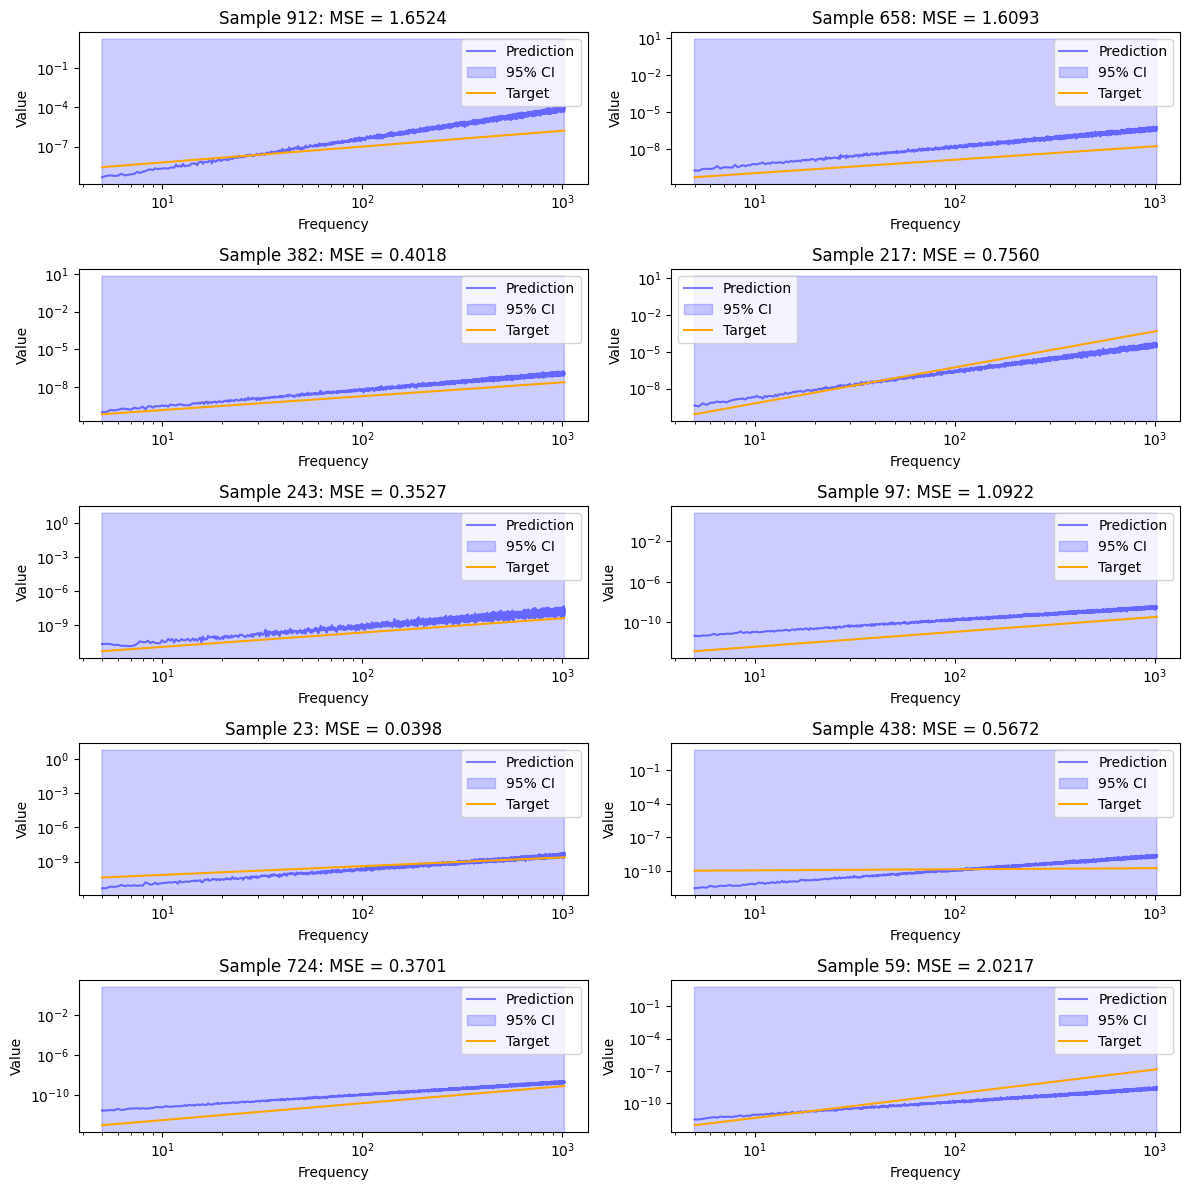

In log space


In [41]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ensure model is in evaluation mode once
model.eval()

num_samples = 10

random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 5
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols

    # Directly use the pre-unscaled predictions and targets
    pred = unscaled_predictions[idx]
    target = unscaled_targets[idx]

    # Compute mean and 95% CI
    samples_mean = 10**np.mean(pred)
    samples_std = 10**np.std(pred)
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std

    # Calculate MSE
    mse = np.mean((pred - target) ** 2)

    # Plot
    axs[row, col].loglog(sim.freq, 10**pred, label='Prediction', color='blue', alpha = 0.5)
    axs[row, col].fill_between(sim.freq, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].loglog(sim.freq,10**target, label='Target', color='orange')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    axs.flat[i].axis('off')

plt.tight_layout()
plt.show()
print('In log space')